# CIFAR-100 Transfer Convolutional Neural Network (TCNN)
In this example we will go through the process of creating a transfer convolutional neural network for the CIFAR-100 dataset. A transfer network uses a pre-built architecture and trains it to work for your data. The CIFAR-100 dataset is a large dataset containing 100 classes which are grouped into 20 superclasses.

## Download the CIFAR-100 Dataset:
Let's begin by downloading the CIFAR-100 Dataset.
Follow the steps below:
- Go to __[this link](https://www.cs.toronto.edu/~kriz/cifar.html)__ and scroll down to the CIFAR-100 dataset section
- Click the link to download the CIFAR-100 python version
- Make a note of the location of this download or move it to a new location for later use
- Extract the compressed files from your .tar download

## Import the necessary libraries:

In [1]:
# import libraries
from matplotlib import pyplot as plt
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torchvision
import torchvision.transforms as transforms
from torchscan import summary
from skimage.io import imsave, imread
from skimage import io,transform
import warnings
import PIL
from PIL import Image
warnings.filterwarnings('ignore')
torch.manual_seed(33)
import numpy as np

In [2]:
# used to install libraries if error with import
# substitute library name after --user argument and restart kernel after install

# import sys
# !{sys.executable} -m pip install --user torchscan

In [3]:
# make code device agnostic
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# view library versions
!pip3 list

Package                  Version
------------------------ ----------
anyio                    3.5.0
argon2-cffi              21.3.0
argon2-cffi-bindings     21.2.0
asttokens                2.0.5
attrs                    22.1.0
Babel                    2.11.0
backcall                 0.2.0
beautifulsoup4           4.12.0
bleach                   4.1.0
boltons                  23.0.0
brotlipy                 0.7.0
certifi                  2022.12.7
cffi                     1.15.1
charset-normalizer       2.0.4
cmake                    3.26.3
comm                     0.1.2
conda                    23.3.1
conda-content-trust      0.1.3
conda-package-handling   2.0.2
conda_package_streaming  0.7.0
contourpy                1.0.7
cryptography             38.0.4
cycler                   0.11.0
debugpy                  1.5.1
decorator                5.1.1
defusedxml               0.7.1
entrypoints              0.4
executing                0.8.3
fastjsonschema           2.16.2
filelock          

## Reformat the extracted CIFAR-100 data:
Before we can begin building a dataclass or preview images we need to reformat the extracted files. The function below will help handle this.

In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Now that the function is defined, create a variable containing the path to each file. 

In [6]:
train_dir = '/home/jcc/jupyter/GII/CIFAR_100_CNN/cifar-100-python/train'
print(f"train:\nBefore unpickle(): {type(train_dir)}") # look at the data type before using unpickle()
train = unpickle(train_dir) # reformat file and save as a new variable
print(f"After unpickle(): {type(train)}") # look at the data type after using unpickle()

test_dir = '/home/jcc/jupyter/GII/CIFAR_100_CNN/cifar-100-python/test'
test = unpickle(test_dir) # reformat test file
print(f"\ntest:\n{type(test)}")

meta_dir = '/home/jcc/jupyter/GII/CIFAR_100_CNN/cifar-100-python/meta'
meta = unpickle(meta_dir) # reformat meta file
print(f"\nmeta:\n{type(meta)}")

train:
Before unpickle(): <class 'str'>
After unpickle(): <class 'dict'>

test:
<class 'dict'>

meta:
<class 'dict'>


## Get more information about our new dictionaries:
Begin with the train_data dictionary.

In [7]:
print(train.keys()) # look at the contents of the dictionary

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])


In [8]:
for i in train: # print the data type of each key
    print(i, type(train[i]))

b'filenames' <class 'list'>
b'batch_label' <class 'bytes'>
b'fine_labels' <class 'list'>
b'coarse_labels' <class 'list'>
b'data' <class 'numpy.ndarray'>


In [9]:
# look at contents of each key
# print(f"File names: {set(train[b'filenames'])}") # uncomment to preview, very large print
print(f"Batch label: {set(train[b'batch_label'])}")
print(f"\nFine labels: {set(train[b'fine_labels'])}")
print(f"\nCoarse labels: {set(train[b'coarse_labels'])}")
print(f"\nData: {train[b'data']}")

Batch label: {32, 97, 98, 99, 102, 103, 104, 105, 110, 111, 49, 114, 116}

Fine labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}

Coarse labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

Data: [[255 255 255 ...  10  59  79]
 [255 253 253 ... 253 253 255]
 [250 248 247 ... 194 207 228]
 ...
 [248 240 236 ... 180 174 205]
 [156 151 151 ... 114 107 126]
 [ 31  30  31 ...  72  69  67]]


In [10]:
train[b'data'].shape # since this has the pixel data, check the shape

(50000, 3072)

In [11]:
train_data = train[b'data'] # save our image data into a new variable

### Summary of train dictionary:
- Fine label corresponds to the image class
- Coarse label corresponds to the image superclass
- Image data is stored in a numpy array of size (50000, 3072)

Now apply the same process to test.

In [12]:
print(f"{test.keys()}\n") # look at the contents of the dictionary

for i in test: # print the data type of each key
    print(i, type(test[i]))

# look at contents of each key
# print(f"\nFile names: {set(test[b'filenames'])}") # uncomment to preview, very large print
print(f"\nBatch label: {set(test[b'batch_label'])}")
print(f"\nFine labels: {set(test[b'fine_labels'])}")
print(f"\nCoarse labels: {set(test[b'coarse_labels'])}")
print(f"\nData: {test[b'data']}")
print(test[b'data'].shape)

test_data = test[b'data'] # save our image data into a new variable

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

b'filenames' <class 'list'>
b'batch_label' <class 'bytes'>
b'fine_labels' <class 'list'>
b'coarse_labels' <class 'list'>
b'data' <class 'numpy.ndarray'>

Batch label: {32, 97, 98, 99, 101, 102, 103, 104, 105, 110, 111, 49, 115, 116}

Fine labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}

Coarse labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

Data: [[199 196 195 ... 215 211 183]
 [113  88  72 ...  96  80  67]
 [ 61  61  67 ... 189 115  89]
 ...
 [ 24  24  22 ...  20  54  54]
 [ 86  93  28 ... 119 115 109]
 [246 240 214 ... 114 

### Summary of test dictionary:
- Fine label corresponds to the image class
- Coarse label corresponds to the image superclass
- Image data is stored in a numpy array of size (10000, 3072)

Finally, look at the meta dictionary.

In [13]:
print(f"{meta.keys()}\n") # look at the contents of the dictionary

for i in meta: # print the data type of each key
    print(i, type(meta[i]))
    
# look at key contents
print(f"\nFine label names: {set(meta[b'fine_label_names'])}")
print(f"\nCoarse label names: {set(meta[b'coarse_label_names'])}")
coarse = meta[b'coarse_label_names'] # create variable to store for later use
fine = meta[b'fine_label_names'] # create variable to store for later use

dict_keys([b'fine_label_names', b'coarse_label_names'])

b'fine_label_names' <class 'list'>
b'coarse_label_names' <class 'list'>

Fine label names: {b'wolf', b'flatfish', b'crocodile', b'lamp', b'raccoon', b'beaver', b'caterpillar', b'plain', b'lobster', b'seal', b'lizard', b'chimpanzee', b'tank', b'mountain', b'pear', b'rocket', b'wardrobe', b'plate', b'worm', b'orange', b'trout', b'dinosaur', b'bowl', b'sea', b'snail', b'mushroom', b'kangaroo', b'house', b'lawn_mower', b'shrew', b'squirrel', b'bottle', b'bridge', b'whale', b'skunk', b'bus', b'tiger', b'willow_tree', b'can', b'girl', b'pickup_truck', b'apple', b'cloud', b'mouse', b'bee', b'man', b'woman', b'camel', b'turtle', b'snake', b'lion', b'motorcycle', b'aquarium_fish', b'keyboard', b'elephant', b'porcupine', b'hamster', b'otter', b'train', b'tulip', b'cattle', b'couch', b'television', b'fox', b'table', b'forest', b'clock', b'poppy', b'ray', b'maple_tree', b'chair', b'streetcar', b'butterfly', b'bed', b'bear', b'boy', b'cup', b

### Summary of meta dictionary:
- Contains the name corresponding to each class and superclass

## Preview an image:
Per the documentation for the CIFAR-100 dataset:
- Each row of the array stores a 32x32 color image
- The first 1024 entries contain the red channel values
- The next 1024 entries contain the green channel values
- The final 1024 entries contain the blue channel values
- The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the first image

Recall that a 32x32 RGB image takes the shape (32,32,3)

<class 'numpy.ndarray'>
Before reshape: (3072,)
After reshape and transpose: (32, 32, 3)
b'large_omnivores_and_herbivores'
 b'cattle'


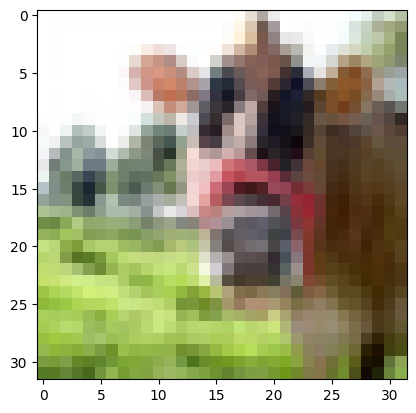

In [14]:
# read the first image from our train data set
train_img = train_data[0] # the image is the first row
print(type(train_img)) # look at data type
print(f"Before reshape: {train_img.shape}") # print initial shape
train_img = train_img.reshape(3,32,32) # reshape the image to display
train_img = train_img.transpose(1,2,0) # transpose the image to display
print(f"After reshape and transpose: {train_img.shape}") # print shape after transformation
train_img = train_img[:,:,:]
plt.imshow(train_img) # display image
print(f"{coarse[train[b'coarse_labels'][0]]}\n {fine[train[b'fine_labels'][0]]}") # display image labels

## Preview more images with their labels:
Create arrays to store 16 images from the train_data array and the respective labels.

In [15]:
cl = [] # array to store coarse labels
fl = [] # array to store fine labels
imgs = [] # array to store image data
for i in range(1,17):
    fl.append(train[b'fine_labels'][i]) # add value for fine label to fl array
    cl.append(train[b'coarse_labels'][i]) # add value for coarse label to cl array
    x = train_data[i] # load the image from train_data array
    x = x.reshape(3,32,32) # transform the image to be displayed
    x = x.transpose(1,2,0)
    imgs.append(x)

img1 shape: (32, 32, 3)

b'vehicles_1'
 b'bicycle'


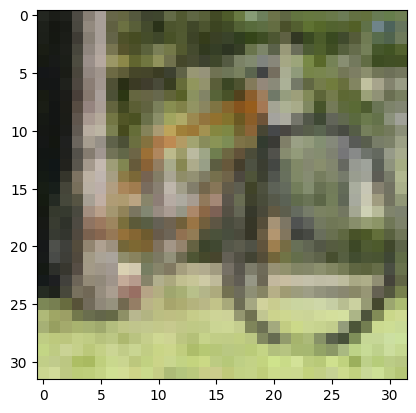

In [16]:
# Look at the shape and display img15
print(f"img1 shape: {imgs[15].shape}\n") # confirm shape of image
plt.imshow(imgs[15]) # display image
print(f"{coarse[cl[15]]}\n {fine[fl[15]]}") # display image labels

### Create the plot for the images and their labels:
Use the arrays created above to define a plot and view multiple images and their labels at the same time.

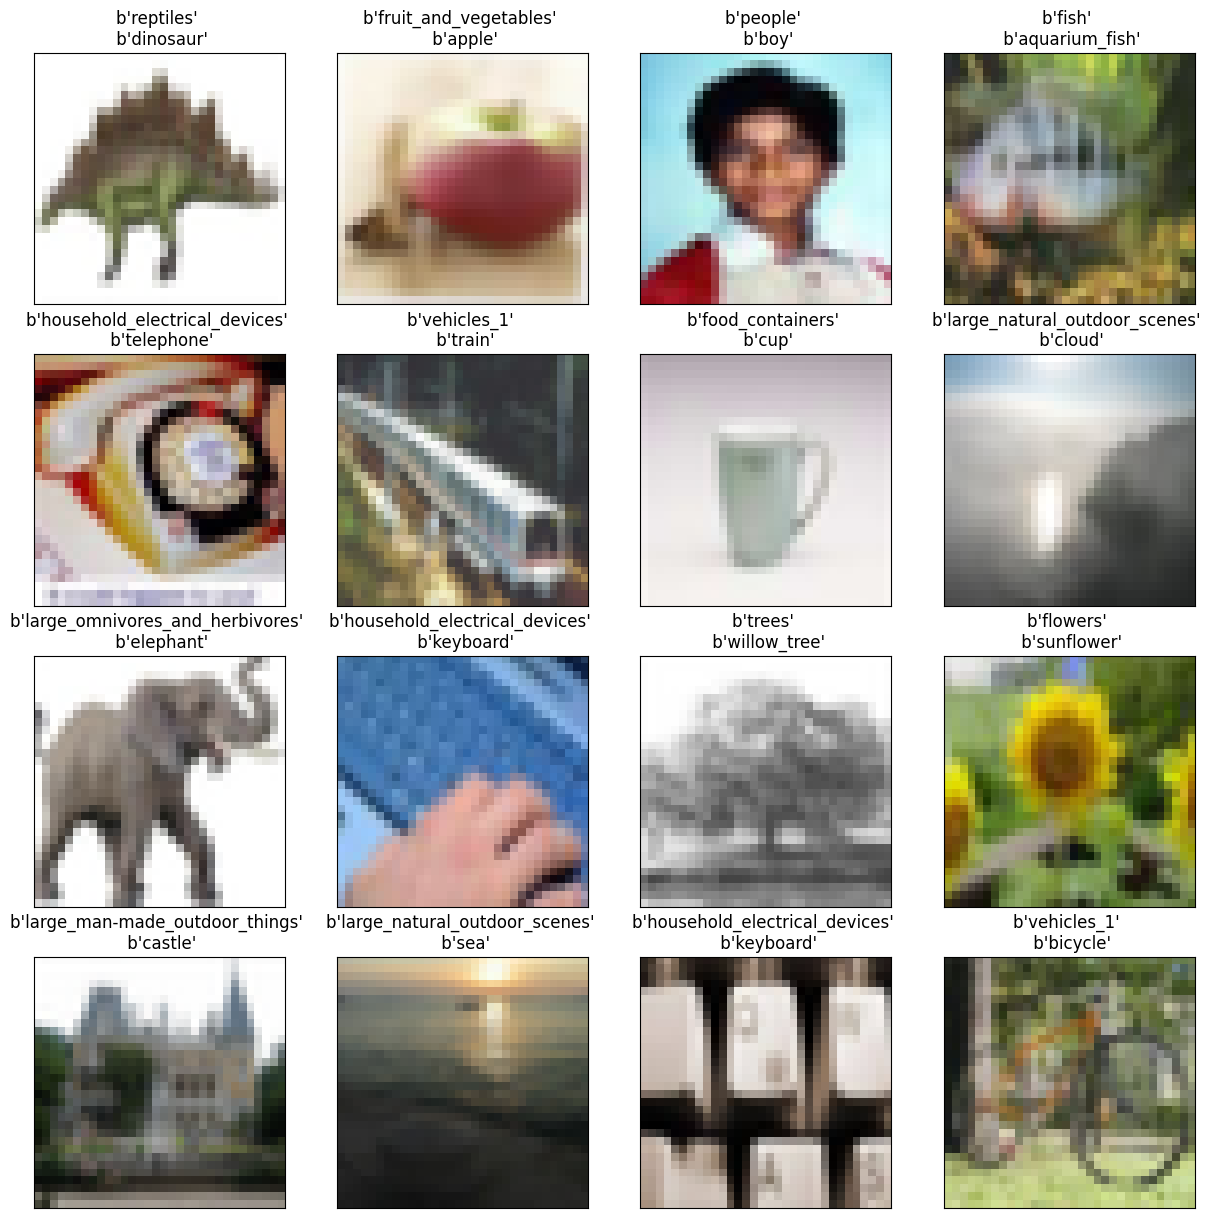

In [17]:
# 4x4 display
rows, columns = 4,4 # create variables to edit subplot shape
plot = plt.figure(figsize=(15, 15)) # create plot and adjust size (x,y)
for i in range(1, columns*rows+1): # range needs to start at 1
    plot.add_subplot(rows, columns, i) # add image i to subplot 
    plt.imshow(imgs[i-1])
    plt.xticks([]), plt.yticks([]) # turn off ticks on x and y axis (30 pixels x 30)
    plt.title("{} \n {}" # add coarse and fine label above image
          .format(meta[b'coarse_label_names'][cl[i-1]], meta[b'fine_label_names'][fl[i-1]]))
plt.show() # display plot

## Choose a pretrained model:

When choosing a pretrained model to build the transfer network there are some important factors to take into consideration.

- Input: choosing a pretrained model with similar or acceptable input dimensions will likely be more successful
  - Be sure to read the documentation to ensure the input has the proper dimensions and the data is normalized appropriately 
- Complexity: some pretrained models might be overkill and can lead to issues such as overfitting
- Parameters: it is possible to either import the default weights or retrain the model on new data

### Densenet

For this demonstration we will use one of the pretrained Densenet models. Densenet is a popular pretrained model for image classification and has very good documentation on both __[github](https://github.com/liuzhuang13/DenseNet)__ and __[pytorch](https://pytorch.org/vision/stable/models/densenet.html)__.

Pytorch has 4 different version to choose from. Each version has differences such as the number of parameters.

Looking at the pytorch documentation for each version reveals key information:
- accuracies for ImageNet-1k dataset based on epochs
- minimum input size (29,29)
- number of parameters
- necessary preprocessing operations

### Densenet161

- Minimum size: height=29,width=29 (this is compatible with our dataset)
- Parameters: 28,681,000 (this is a complex model, it could take a while and test for overfitting at the end)
- For default weights:
  - values scaled [0.0, 1.0]
  - normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
- Alternatively, don't need to transform if initial weights aren't set

### Densenet121

- For a better performance on the Jetson Nano GPU or 4090 use Densenet121
- This model has the same transforms, but the model is more smaller with less parameters
- This will help avoid memory issues

## Create a dataset class:

This class will make it quick and easy to format all of the images for the model.

First we will practice the preprocessing to ensure it looks right.

Negative values are alright after the data is processed.

(torch.Size([3, 224, 224]),
 tensor([[[ 1.7694,  1.7523,  1.7523,  ..., -1.0219, -1.0390, -1.0562],
          [ 1.7352,  1.7352,  1.7180,  ..., -1.0390, -1.0562, -1.0733],
          [ 1.7180,  1.7009,  1.7009,  ..., -1.0562, -1.0733, -1.0904],
          ...,
          [-0.2513, -0.3198, -0.3712,  ..., -0.6109, -0.5082, -0.4054],
          [-0.3712, -0.4397, -0.4739,  ..., -0.6623, -0.5596, -0.4568],
          [-0.4911, -0.5424, -0.5938,  ..., -0.7137, -0.6109, -0.5082]],
 
         [[ 1.8859,  1.8859,  1.8859,  ..., -0.6527, -0.6702, -0.6877],
          [ 1.8683,  1.8508,  1.8508,  ..., -0.6702, -0.6877, -0.7052],
          [ 1.8333,  1.8158,  1.8158,  ..., -0.6877, -0.7052, -0.7227],
          ...,
          [-0.2500, -0.3200, -0.3901,  ..., -0.2500, -0.1450, -0.0399],
          [-0.3725, -0.4426, -0.5126,  ..., -0.3025, -0.1975, -0.0924],
          [-0.4951, -0.5651, -0.6176,  ..., -0.3550, -0.2500, -0.1450]],
 
         [[ 2.0997,  2.0823,  2.0823,  ..., -1.4384, -1.4559, -1.4733],


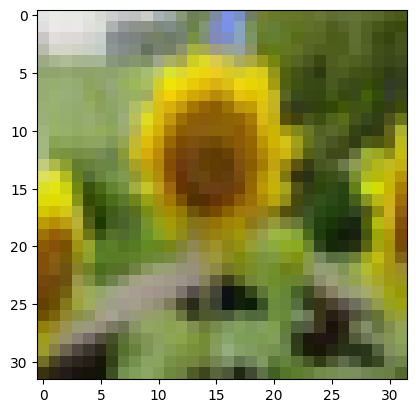

In [18]:
# this code section is used to test the transformation process and preview results
img12 = train_data[12]
img12 = img12.reshape(3,32,32) # transform image
img12 = img12.transpose(1,2,0)
img12 = img12/255
plt.imshow(img12)

# convert to PIL image and shape so we can transform appropriately
img12 = Image.fromarray(np.uint8(img12*255),mode='RGB')

# transform (needs to be in PIL format for this function and input (C,H,W))
weights = torchvision.models.DenseNet121_Weights.DEFAULT
preprocess = weights.transforms()
img12 = preprocess(img12)

img12.shape, img12

#img12 = img12.reshape(224,224,3)

#plt.imshow(img12)

In [19]:
class ImageData(Dataset):
    def __init__(self,datavar,flabeldict):
        super().__init__()
        self.image = datavar
        self.flabel = flabeldict
        
    def __len__(self): # function to determine number of images in dataset
        return(len(self.image))
    
    def __getitem__(self,idx): # retrieve image and corresponding labels
        
        # 3 channels
        img = self.image[idx] # img stores row 'idx' from image array datavar
        img = img.reshape(3,32,32) # transform image
        img = img.transpose(1,2,0)
        
        # normalize the image data to convert to PIL (needs to be values [0.0,1.0]
        img = img/255
        
        # convert to PIL image and shape so we can transform appropriately
        img = Image.fromarray(np.uint8(img*255),mode='RGB')
        
        # transform (needs to be in PIL format for this function and input (C,H,W))
        weights = torchvision.models.DenseNet121_Weights.DEFAULT
        preprocess = weights.transforms()
        img = preprocess(img)
        
        flabel = self.flabel[idx]
        
        return img.float(),torch.tensor(flabel).float()

### Create datasets using the dataset class:
Recall the class takes inputs in the order of imagedata, coarse label dictionary, fine label dictionary.

In [20]:
image_set_train = ImageData(train_data,train[b'fine_labels'])
image_set_test = ImageData(test_data,test[b'fine_labels'])

### Test the getitem function:
- Test by loading the 0th row from train_data and the respective labels
- Verify by plotting the image and labels
- Recall from earlier train_data[0] corresponds to b'large_omnivores_and_herbivores' and b'cattle'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Fine label: (tensor(19.), torch.Size([]))     
Image data: tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  0.9303,  0.8789,  0.8447],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.9646,  0.9132,  0.8789],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.9988,  0.9474,  0.9132],
         ...,
         [ 0.2453,  0.2453,  0.2282,  ..., -1.4843, -1.3987, -1.3130],
         [ 0.1939,  0.2111,  0.1939,  ..., -1.4843, -1.3987, -1.2959],
         [ 0.1597,  0.1768,  0.1597,  ..., -1.4843, -1.3815, -1.2788]],

        [[ 2.4286,  2.4286,  2.4286,  ...,  1.2206,  1.1856,  1.1681],
         [ 2.4286,  2.4286,  2.4286,  ...,  1.2731,  1.2206,  1.2031],
         [ 2.4286,  2.4286,  2.4286,  ...,  1.3081,  1.2731,  1.2381],
         ...,
         [ 1.0455,  1.0455,  1.0455,  ..., -1.5630, -1.4405, -1.3179],
         [ 0.9930,  0.9930,  0.9930,  ..., -1.5455, -1.4055, -1.2654],
         [ 0.9405,  0.9405,  0.9580,  ..., -1.5280, -1.3704, -1.2304]],

        [[ 2.6400,  2.6400,  2.6400,  ...,  0.8971,  0.82

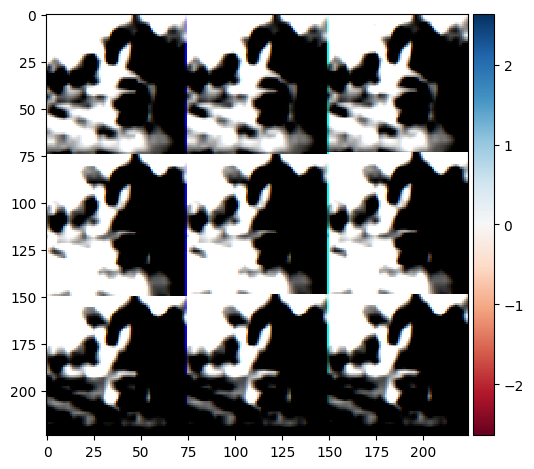

In [21]:
print(f"Fine label: {image_set_train.__getitem__(0)[1], image_set_train.__getitem__(0)[1].shape} \
    \nImage data: {image_set_train.__getitem__(0)[0]}")

# plot the image to verify
img0 = image_set_train.__getitem__(0)[0] # get item (0) and image [0] and see shape
print(f"\nImage shape after __getitem__ function: {img0.shape}")
img0 = img0.numpy().squeeze() # squeeze to format for image display
print(f"Image shape after squeeze: {img0.shape}")

# 3 channels
img0 = img0.reshape(224,224,3)
print(f"Image shape after reshape: {img0.shape}")

flab = image_set_train.__getitem__(0)[1]
flab = flab.numpy().squeeze().astype(int)
print(f"\nFine label: {meta[b'fine_label_names'][flab]}")

io.imshow(img0) # display image
plt.show()

## Dataloaders:
Now that we've confirmed our dataset class and getitem function work as intended, use the imported DataLoader function to create batches for the model.

The function uses the arguments:
- 0: data set created from class
- batch_size: the number of items in each batch
- shuffle: randomize the items of each batch, this is especially important to prevent bias when the data set is very ordered

In [22]:
# reduced batch size to 5 to prevent memory issues with Jetson Nano or 4090
train_loader = DataLoader(image_set_train,batch_size=5,shuffle=True)
test_loader = DataLoader(image_set_test,batch_size=5,shuffle=True)
input,ftarget = next(iter(train_loader))
print(input.shape,ftarget.shape)

torch.Size([5, 3, 224, 224]) torch.Size([5])


## Build the model:
Create a class for the transfer CNN model.
- Import the model with default weights
  - the transformations can be included in this part referencing the documentation
- Output layer for each label
- Define feed-forward function and return outputs

In [70]:
class DenseNet(nn.Module):
    def __init__(self,in_channels=3):
        super(DenseNet,self).__init__()
        
        # import the pretrained model with default weights and transformations
        self.model = torch.hub.load('pytorch/vision:v0.15.1','densenet121',pretrained=True)
        
        # layers feeding out of densenet
        num_ftrs = self.model.classifier.in_features # classifier layer number of in_features
        self.model.classifier = nn.Linear(num_ftrs,100) # classifier layer corresponding to our number of labels
        
    def forward(self,x): # pass forward function
        f_label = self.model(x) # send through model
        return f_label

### Create the model and view summary of input with proper shape.

In [81]:
Dense = DenseNet().to(device) # intialize a variable to store our model

Using cache found in /home/jcc/.cache/torch/hub/pytorch_vision_v0.15.1


## Test the model:

Create a test tensor with the dimensions of the mini-batches to ensure the output from the CNN is in the proper format

In [82]:
test_ten = torch.randn((5,3,224,224)) # batch size, channels, image size
fine_test = Dense(test_ten.to(device)) # output variable to store model output for test tensor

print(f"Fine shape: {fine_test.shape}\n{fine_test}")
# print(Dense)

Fine shape: torch.Size([5, 100])
tensor([[ 9.4511e-01, -5.1738e-01,  1.4647e-01, -7.5249e-02,  2.2048e-01,
          2.2049e-01, -1.4284e-01,  2.2815e-01,  2.1021e-01, -3.2810e-01,
         -6.3481e-01, -8.5673e-01, -3.9268e-01, -1.4585e-01, -9.2753e-01,
          1.2798e+00,  4.7756e-01,  7.2401e-01, -1.3016e-01,  2.2200e-01,
          1.6429e-01,  1.3733e-01, -6.8989e-01, -1.7478e-01, -3.2612e-01,
          9.4532e-02,  9.0937e-02,  4.6353e-01, -1.4547e-01,  8.2602e-02,
          1.3070e-01, -3.4797e-01,  5.5219e-01, -3.6459e-01, -9.5725e-02,
          9.0994e-01,  2.2511e-01, -4.6599e-01, -9.1875e-01,  8.3188e-04,
          2.2535e-01, -3.6655e-01, -6.7351e-03, -7.6003e-01,  2.7820e-01,
         -7.3288e-01, -9.5954e-02, -1.1052e+00, -2.5612e-01,  3.5227e-01,
         -2.1392e-01, -1.2979e-01, -2.8576e-01,  5.2971e-01,  1.1182e+00,
          5.6139e-01,  8.8391e-02,  3.6265e-01, -2.8309e-01,  5.5517e-02,
         -1.7880e-01, -5.4459e-01,  2.6909e-01, -9.2065e-01, -6.3398e-01,
     

In [83]:
# use torchscan to see summary since torchsummary has compatability issues with densenet
# summary(Dense,(3,224,224)) # produce a summary of the model to see details such as trainable params, etc.

In [84]:
# choose whether or not to freeze parameters in transfer network
# for param in Dense.model.features.parameters():
#     param.requires_grad = False

In [85]:
# look at a summary again to ensure the only trainable params are in the output fc layer
# summary(Dense,(3,224,224))

In [ ]:
# note for this demo performance is better not freezing parameters so these blocks are commented out above

In [86]:
# set up parameters for training/testing
lr = 0.0001 # learning rate
n_epochs = 5 # number of epochs to train/test
loss_fn = nn.CrossEntropyLoss() # loss function
log_interval = 1000 # interval for updating print output in test/train
optimizer = optim.Adam(Dense.parameters(),lr=lr) # intialize optimizer

# output arrays
train_losses = [] # store loss values in training
train_counter = [] # store length to compute accuracy and other characteristics
test_losses = [] # store test loss values
test_counter = [i*len(image_set_train) for i in range(n_epochs + 1)]

In [87]:
# training function
def train(epoch):
    Dense.train() # put the model in training mode
    for batch_idx, (data, ftarget) in enumerate(train_loader): # main loop; iterate through train_loader
        data,ftarget = data.float(),ftarget.long() # create variables for model data and outputs
        optimizer.zero_grad() # zero the gradient
        out1 = Dense(data.to(device)) # store model output into variables
        
        # squeeze output and targets to format for loss function
        out1 = torch.squeeze(out1) # model output for fine label
        ftarget = torch.squeeze(ftarget) # fine label targets from dataloaders and dataclass
        
        loss1 = loss_fn(out1.to(device),ftarget.to(device)) # feed fine output and targets into our loss function to find loss
        loss = loss1 # the loss for the model is the sum of the loss value for each output
        loss.backward() # calculate gradients
        optimizer.step() # update model
        
        # print out information about the progress and update output arrays for training
        if batch_idx % log_interval == 0: # periodicity using interval previously defined
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(image_set_train),
                100. * batch_idx* len(data) / len(image_set_train), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(image_set_train)))
            torch.save(Dense.state_dict(), 'Dense.pth') # save the model and optimizer states in files
            torch.save(optimizer.state_dict(), 'Dense_results.pth')

In [88]:
# testing function
def test():
    Dense.eval() # place model in testing mode
    print("Testing...")
    test_loss = 0
    f_correct = 0 # number of fine labels correct
    with torch.no_grad():
        for data, ftarget in test_loader:
            data,ftarget = data.float(),ftarget.long() # format for loss
            #print(data.shape)
            out1 = Dense(data.to(device)) # store output from model in variable
                        
            out1 = torch.squeeze(out1) # squeeze dimensions to format for loss
            
            ftarget = torch.squeeze(ftarget)
            
            loss = loss_fn(out1.to(device),ftarget.to(device)) # compute loss value for first output
            test_loss += loss.item() # append loss value to evaluate model
            fpred = out1.data.max(1, keepdim=True)[1]
            f_correct += fpred.eq(ftarget.data.view_as(fpred).to(device)).sum() # if fpred matches label add tally
    test_loss /= len(test_loader) # calculate test loss
    test_losses.append(test_loss) # add test loss to array
    print('\nTest set: Avg. loss: {:.4f}, Fine Accuracy: {}/{} ({:.0f}%)\n'.format( # print output about testing
        test_loss,
        f_correct, len(image_set_test), 100. * f_correct / len(image_set_test)))

In [89]:
# libraries for analysis of training/testing
import time
from datetime import timedelta

start_time = time.time() # initialize start time

# Perform lots of computations.

test() # run initial test of model before training
for epoch in range(1, n_epochs + 1): # run training epochs and test at end of each training period
    train(epoch) # train model for each epoch
    test() # test model again after each train
    
elapsed_time_secs = time.time() - start_time # caluclate total time for training/testing

msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs)) # output message

print(msg)

Testing...

Test set: Avg. loss: 4.7666, Fine Accuracy: 101/10000 (1%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 4.553071
Train Epoch: 1 [5000/50000 (10%)]	Loss: 3.364814
Train Epoch: 1 [10000/50000 (20%)]	Loss: 3.026428
Train Epoch: 1 [15000/50000 (30%)]	Loss: 1.968234
Train Epoch: 1 [20000/50000 (40%)]	Loss: 2.270235
Train Epoch: 1 [25000/50000 (50%)]	Loss: 1.879888
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.736244
Train Epoch: 1 [35000/50000 (70%)]	Loss: 1.024963
Train Epoch: 1 [40000/50000 (80%)]	Loss: 3.267828
Train Epoch: 1 [45000/50000 (90%)]	Loss: 2.330212
Testing...

Test set: Avg. loss: 1.0587, Fine Accuracy: 6890/10000 (69%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.990543
Train Epoch: 2 [5000/50000 (10%)]	Loss: 1.083578
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.647879
Train Epoch: 2 [15000/50000 (30%)]	Loss: 0.510406
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.925626
Train Epoch: 2 [25000/50000 (50%)]	Loss: 1.729995
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.041916
Train Epoch: 2 [

## Observe the performance of the model:

Now that the model has finished testing and training we are able to plot the respective losses.

In [90]:
len(test_counter), print(test_counter)

[0, 50000, 100000, 150000, 200000, 250000]


(6, None)

In [91]:
len(test_losses),print(test_losses)

[4.766572617411613, 1.0586940951577852, 1.011102823673893, 0.8921987101646955, 0.8972925097283659, 0.8919617394812376]


(6, None)

Text(0, 0.5, 'loss value')

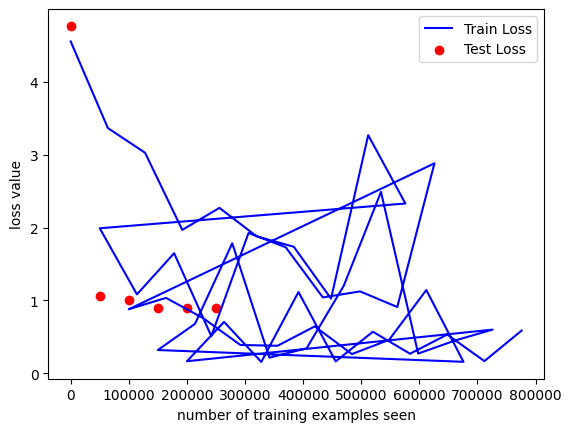

In [92]:
fig = plt.figure() # create a plot
plt.plot(train_counter,train_losses,color='blue') # define the characteristics of the train plot
plt.scatter(test_counter,test_losses,color='red') # define the characteristics of teh test plot
plt.legend(['Train Loss','Test Loss'],loc='upper right') # create a legend and define location
plt.xlabel('number of training examples seen') # label for x axis
plt.ylabel('loss value') # label for y axis

## Test the model with sample images from the internet:

- Let's test the model we made with some images from the web
- Add some images to the directory containing your .ipynb file and saved models
- Below we will look at the labels and create a function to classify untrained images

In [93]:
print(f"Fine Labels:\n{fine}")

Fine Labels:
[b'apple', b'aquarium_fish', b'baby', b'bear', b'beaver', b'bed', b'bee', b'beetle', b'bicycle', b'bottle', b'bowl', b'boy', b'bridge', b'bus', b'butterfly', b'camel', b'can', b'castle', b'caterpillar', b'cattle', b'chair', b'chimpanzee', b'clock', b'cloud', b'cockroach', b'couch', b'crab', b'crocodile', b'cup', b'dinosaur', b'dolphin', b'elephant', b'flatfish', b'forest', b'fox', b'girl', b'hamster', b'house', b'kangaroo', b'keyboard', b'lamp', b'lawn_mower', b'leopard', b'lion', b'lizard', b'lobster', b'man', b'maple_tree', b'motorcycle', b'mountain', b'mouse', b'mushroom', b'oak_tree', b'orange', b'orchid', b'otter', b'palm_tree', b'pear', b'pickup_truck', b'pine_tree', b'plain', b'plate', b'poppy', b'porcupine', b'possum', b'rabbit', b'raccoon', b'ray', b'road', b'rocket', b'rose', b'sea', b'seal', b'shark', b'shrew', b'skunk', b'skyscraper', b'snail', b'snake', b'spider', b'squirrel', b'streetcar', b'sunflower', b'sweet_pepper', b'table', b'tank', b'telephone', b'tele

In [94]:
def classify(model,image,f_classes):

    #plt.imshow(image)

    # transform (needs to be in PIL format for this function and input (C,H,W))
    weights = torchvision.models.DenseNet121_Weights.DEFAULT
    preprocess = weights.transforms()
    image = preprocess(image)
    
    # convert to numpy to preview output from transformations
    image = torch.Tensor.numpy(image)
    image = image.reshape(224,224,3)
    io.imshow(image)
    plt.show()

    #print(image.shape)
    
    # place the model in test mode and format images for model
    model = model.eval()
    image = torch.from_numpy(image) # convert image back into tensor
    image = image.float()
    image = image.reshape(3,224,224) # shape for model input
    image = image.unsqueeze(0) # add extra dimension to represent batch size [1,3,224,224]
    
    print(image.shape) # preview output size that will input to model
    
    output = model(image.to(device)) # pass image through model to classify
    #print(f"Predictions: \n{output}\n")
    _,fpredicted = torch.max(output.data,1) # calculate label by finding max probability in output tensor
    #print(fpredicted)
    print(f"Predicted Fine: {f_classes[fpredicted]}\n") # print corresponding label name (not necessary but helpful)

<function matplotlib.pyplot.show(close=None, block=None)>

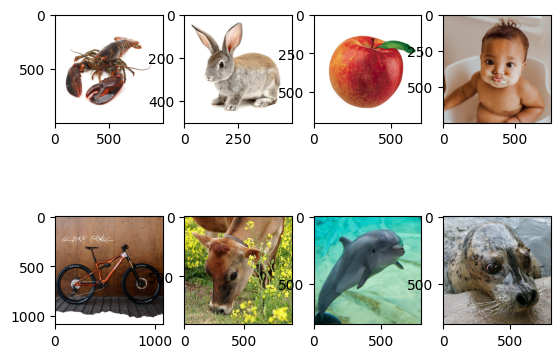

In [95]:
# read and normalize .png files
lobster = io.imread('lobster.png') / 255
rabbit = io.imread('rabbit.png') / 255
lobster = lobster[:,:,:3] # get rid of alpha channel for .png file
rabbit = rabbit[:,:,:3]

# read and normalize .jpg files
apple = io.imread('apple.jpg') / 255
baby = io.imread('baby.jpg') / 255
bike = io.imread('bike.jpg') / 255
cow = io.imread('cow.jpg') / 255
dolphin = io.imread('dolphin.jpg') / 255
seal = io.imread('seal.jpg') / 255

# convert images to PIL format for transformations in classify function
lobster = Image.fromarray(np.uint8(lobster*255),mode='RGB')
rabbit = Image.fromarray(np.uint8(rabbit*255),mode='RGB')
apple = Image.fromarray(np.uint8(apple*255),mode='RGB')
baby = Image.fromarray(np.uint8(baby*255),mode='RGB')
bike = Image.fromarray(np.uint8(bike*255),mode='RGB')
cow = Image.fromarray(np.uint8(cow*255),mode='RGB')
dolphin = Image.fromarray(np.uint8(dolphin*255),mode='RGB')
seal = Image.fromarray(np.uint8(seal*255),mode='RGB')

# store images into an array
new_pics = [lobster,rabbit,apple,baby,bike,cow,dolphin,seal]

# plot the images to make sure they look alright before classify function and transformations
f, ax = plt.subplots(2,4)
ax[0,0].imshow(lobster)
ax[0,1].imshow(rabbit)
ax[0,2].imshow(apple)
ax[0,3].imshow(baby)
ax[1,0].imshow(bike)
ax[1,1].imshow(cow)
ax[1,2].imshow(dolphin)
ax[1,3].imshow(seal)
plt.show

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


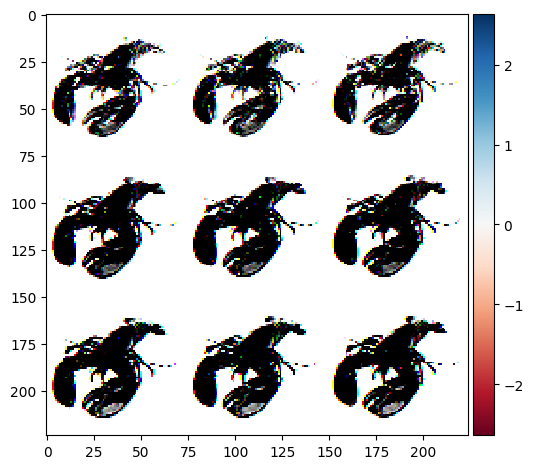

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])
Predicted Fine: b'butterfly'



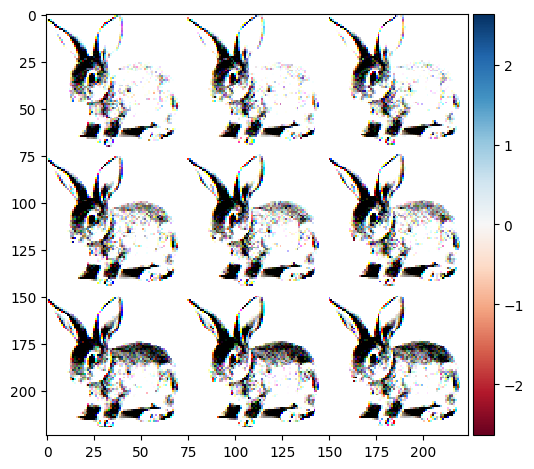

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])
Predicted Fine: b'rabbit'



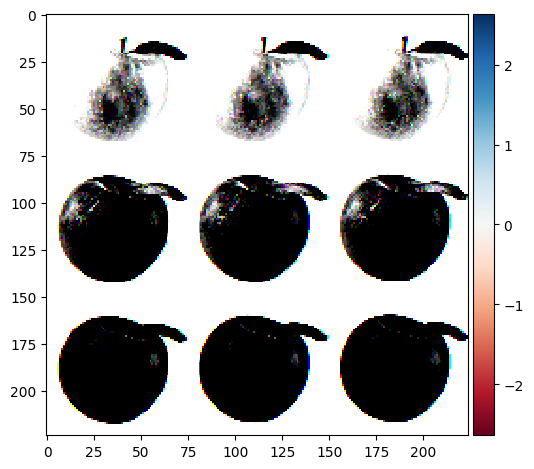

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])
Predicted Fine: b'apple'



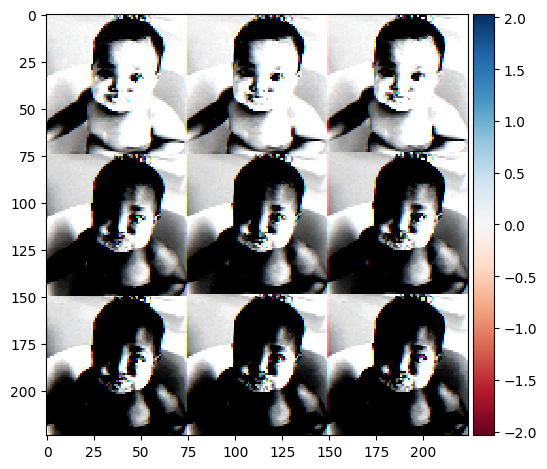

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])
Predicted Fine: b'baby'



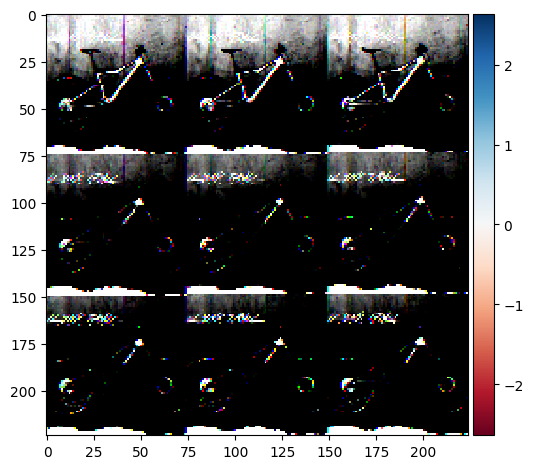

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])
Predicted Fine: b'tiger'



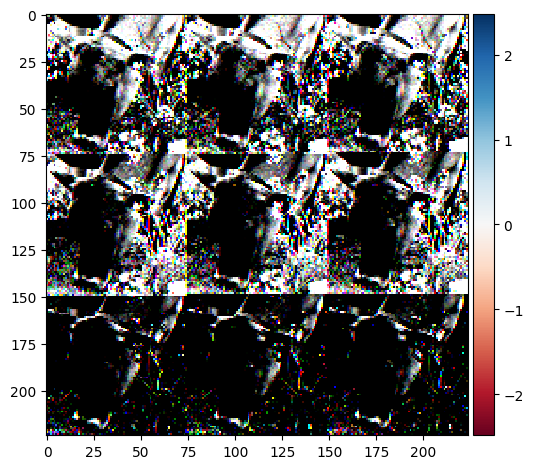

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])
Predicted Fine: b'tiger'



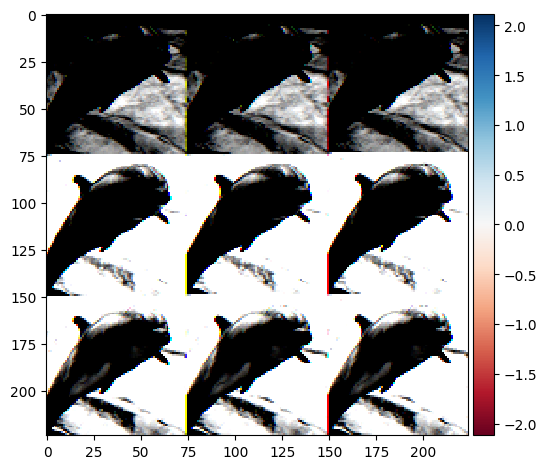

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])
Predicted Fine: b'dolphin'



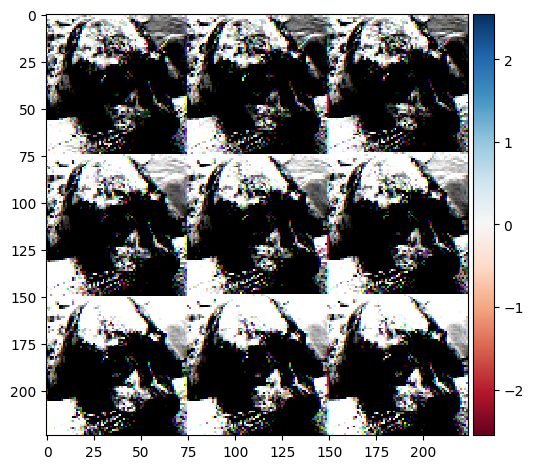

torch.Size([1, 3, 224, 224])
Predicted Fine: b'leopard'



In [97]:
# iterate through untrained images and classify
for i in new_pics:
    classify(Dense,i,fine)

## Summary:
- Looking at the plot of training and test loss we can see test loss decrease rapidly towards the models theoretical maximum performance.
- The accuracy for the test sets improved from 1% to 76% and is much better than the scratch built model with 30%.
- The performance on images from the internet is also much better than the scratch build. 4 of the images were correctly identified and some of the misidentified images are more reasonable.
- This model highlights both the strength of using transfer models and also the performance advantage of a powerful GPU. This model took ~24 minutes to train on the 4090 as compared to hours or days on CPU devices such as a laptop.